In [1]:
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely as sp
import random
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.cm as cm

Legend:
- Line: roadline (linestrings)
- Image: satellite image of patch
- Image Mask: binary mask of detected roads from images (eg. ground truth mask)
- Roadline Mask: roadline (linestring) converted into a binary mask

Read Roadline Data

In [2]:
# Get roadline data
shape = gpd.read_file("data/shapefiles/gis_osm_roads_free_1.shp") #get shape files for road (road lines)
dataset_area = gpd.read_file("data/shapefiles/dataset_area.shp")  #area of dataset
dataset_roads = shape[dataset_area['geometry'].item().contains(shape['geometry'])] #filter shape file for only those within dataset area

dataset_roads['geometry'].set_crs(None, allow_override=True, inplace=True)

0          LINESTRING (121.05212 14.6503, 121.05223 14.65...
2          LINESTRING (120.99671 14.55627, 120.9967 14.55...
3          LINESTRING (120.98539 14.6046, 120.98545 14.60...
4          LINESTRING (120.9938 14.54125, 120.99497 14.54...
5          LINESTRING (120.98018 14.59292, 120.98002 14.5...
                                 ...                        
1494909    LINESTRING (121.07354 14.53426, 121.07351 14.5...
1494910    LINESTRING (121.07365 14.5342, 121.07372 14.53...
1494911    LINESTRING (121.07365 14.5342, 121.07396 14.53...
1494912    LINESTRING (121.07347 14.53411, 121.07333 14.5...
1494913    LINESTRING (121.07351 14.53419, 121.07347 14.5...
Name: geometry, Length: 142331, dtype: geometry

In [3]:
#dataset_roads.head()

Read Footprint Data

In [192]:
# Get building footprints data
footprints_makati = gpd.read_file("data/footprints/Makati Polygons v3.2.geojson")
footprints_manila = gpd.read_file("data/footprints/Manila_polygons_v3.geojson")
footprints_mandaluyong = gpd.read_file("data/footprints/Mandaluyong Polygon v3.geojson")

dataset_footprints = gpd.GeoDataFrame(pd.concat([footprints_makati, footprints_manila, footprints_mandaluyong], ignore_index=True))
dataset_footprints['geometry'].set_crs(None, allow_override=True, inplace=True)

0        MULTIPOLYGON (((121.0309 14.56083, 121.03087 1...
1        MULTIPOLYGON (((121.02055 14.55521, 121.02055 ...
2        MULTIPOLYGON (((121.02418 14.54927, 121.02427 ...
3        MULTIPOLYGON (((121.02705 14.5628, 121.02705 1...
4        MULTIPOLYGON (((121.01556 14.5394, 121.01552 1...
                               ...                        
64642    MULTIPOLYGON (((121.03674 14.58929, 121.03682 ...
64643    MULTIPOLYGON (((121.02996 14.59323, 121.03002 ...
64644    MULTIPOLYGON (((121.04242 14.58867, 121.04218 ...
64645    MULTIPOLYGON (((121.0449 14.5879, 121.04547 14...
64646    MULTIPOLYGON (((121.04527 14.58734, 121.04529 ...
Name: geometry, Length: 64647, dtype: geometry

In [5]:
#dataset_footprints.head()

Constants

In [6]:
LATITUDE_INDEX = -2
LONGITUDE_INDEX = -1
PATCH_SIZE = 512 # Size of the patches
EARTH_CIRCUFERENCE = 40075016.686 # in meters
SEARCH_INTERVAL = 10  # Distance between interpolated points
SEARCH_RANGE = 30 # pixels the road can be adjusted to find the best fit [coords-SEARCH_RANGE, coords+SEARCH_RANGE]
LINE_LENGTH = 20  # Total length of perpendicular lines
MAX_DISTANCE_FROM_ROAD = 50 # Maximum distance a point can be from a road mask
MAX_ROAD_WIDTH = 150 # Maximum width of a road for it to be considered
LAT_SIZE = 0.0013364 # Estimated degrees per 512 pixels (latitude)
LONG_SIZE = 0.00137216 # Estimated degrees per 512 pixels (longitude)
DISPLAY_ALLOWANCE = 0.0
LAT_SHIFT = 0.0
LONG_SHIFT = 0.0

DATA_FOLDER = Path("data/roadimages")
NO_ROADS_FOLDER = "1 _ No Roads"
FOLDER_NAMES = ["\\1 _ No Roads", "\\2 _ Roads with Occlusions", "\\3 _ Clear Regular Roads", "\\4 _ Wide Roads"]

NUM_DISPLAY = 3

File Paths

In [7]:
file_paths = [file_path for file_path in DATA_FOLDER.rglob("*") if file_path.is_file() and NO_ROADS_FOLDER not in file_path.parts]

Dataset Bounds

In [8]:
def get_dataset_roads_bounds(data_folder, no_roads_folder):
    file_names = [file_path.stem for file_path in data_folder.rglob("*") if file_path.is_file() and no_roads_folder not in file_path.parts]
    file_parts = [file_name.split("_") for file_name in file_names]

    sorted_lat = sorted(file_parts, key=lambda x: float(x[LATITUDE_INDEX]))
    sorted_lon = sorted(file_parts, key=lambda x: float(x[LONGITUDE_INDEX]))

    max_lon = float(sorted_lon[-1][LONGITUDE_INDEX])
    min_lon = float(sorted_lon[0][LONGITUDE_INDEX])
    max_lat = float(sorted_lat[-1][LATITUDE_INDEX])
    min_lat = float(sorted_lat[0][LATITUDE_INDEX])

    bounds = {
        "min_lat": min_lat,
        "max_lat": max_lat,
        "min_lon": min_lon,
        "max_lon": max_lon
    }

    return bounds

In [9]:
#bounds = get_dataset_roads_bounds(DATA_FOLDER, NO_ROADS_FOLDER)
#print(bounds)

In [10]:
# centerx, centery = (121.035004, 14.555672)

# offset = 0.00068
# minx, miny, maxx, maxy = (centerx - offset, centery - offset, centerx + offset, centery + offset)
# bbox = sp.geometry.box(minx, miny, maxx, maxy)

# road_patch = dataset_roads.cx[minx:maxx, miny:maxy]
# road_patch.loc[:, 'geometry'] = road_patch['geometry'].apply(lambda geom: geom.intersection(bbox))
# road_patch = road_patch[~road_patch.is_empty]

# road_patch.plot()

# road_patch

In [11]:
# Scale Geometry by a Factor
def scale_geometry(geom, x_scale, y_scale):
    return sp.affinity.scale(geom, xfact=x_scale, yfact=y_scale, origin=(0,0))

# Shift Geometry by a Given Amount
def shift_geometry(geom, x_shift, y_shift):
    return sp.affinity.translate(geom, xoff=-x_shift, yoff=-y_shift)

Display a Patch

In [142]:
#Select a random patch from the dataset
#patch_path = random.choice(file_paths)

#Select specific patches for testing
#patch_path = Path("data\\roadmasks\\30__14.554343_121.002045.png")
#patch_path = Path("data\\roadmasks\\70__14.598202_121.051483.png")
patch_path = Path("data\\roadimages\\3 _ Clear Regular Roads\\13__14.580925_121.030884.png")
print(patch_path)

data\roadimages\3 _ Clear Regular Roads\13__14.580925_121.030884.png


In [143]:
def get_image_mask_image_path(patch_path):
    image_mask_image_path = str(patch_path).replace("roadimages", "roadmasks")

    #Remove folder names from the image_mask_image_path
    for folder_name in FOLDER_NAMES:
        if folder_name in str(patch_path):
            image_mask_image_path = image_mask_image_path.replace(folder_name, "")
    
    return Path(image_mask_image_path)

def get_patch_coordinates(patch_path):
    path_parts = patch_path.stem.split("_")
    latitude = float(path_parts[LATITUDE_INDEX])
    longitude = float(path_parts[LONGITUDE_INDEX])

    coordinates = {
        "latitude": latitude, 
        "longitude": longitude
    }

    return coordinates

def get_patch_bounds(patch_path):
    coordinates = get_patch_coordinates(patch_path)

    min_lat = coordinates["latitude"] - LAT_SIZE / 2
    max_lat = coordinates["latitude"] + LAT_SIZE / 2
    min_lon = coordinates["longitude"] - LONG_SIZE / 2
    max_lon = coordinates["longitude"] + LONG_SIZE / 2

    bounds = {
        "min_lat": min_lat,
        "max_lat": max_lat,
        "min_lon": min_lon,
        "max_lon": max_lon
    }

    return bounds

In [144]:
def get_patch_roadlines(patch_path):
    bounds = get_patch_bounds(patch_path)
    min_lat = bounds["min_lat"]
    max_lat = bounds["max_lat"]
    min_lon = bounds["min_lon"]
    max_lon = bounds["max_lon"]

    patch_roadlines = dataset_roads.cx[min_lon:max_lon, min_lat:max_lat]

    return patch_roadlines, bounds

In [145]:
patch_roadlines, patch_bounds = get_patch_roadlines(patch_path)
patch_roadlines

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
6903,22000401,5122,residential,San Rafael Street,None,B,0,0,F,F,"LINESTRING (121.03027 14.58045, 121.03017 14.5..."
6915,22001376,5122,residential,Santo Niño Street,None,B,0,0,F,F,"LINESTRING (121.03309 14.57897, 121.03304 14.5..."
6918,22001498,5122,residential,Santa Ana Street,None,B,0,0,F,F,"LINESTRING (121.03284 14.58104, 121.03267 14.5..."
6919,22001542,5122,residential,San Joaquin Street,None,B,0,0,F,F,"LINESTRING (121.03243 14.58147, 121.03222 14.5..."
550981,616818168,5115,tertiary,San Rafael Street,None,B,0,0,F,F,"LINESTRING (121.03031 14.58053, 121.03027 14.5..."
617150,680275201,5115,tertiary,San Rafael Street,None,B,0,0,F,F,"LINESTRING (121.03031 14.58053, 121.03081 14.5..."
638927,695757212,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.03082 14.5804, 121.03077 14.58..."
638977,695777124,5114,secondary,Boni Avenue,None,F,40,0,F,F,"LINESTRING (121.03089 14.58004, 121.03079 14.5..."
638978,695777126,5114,secondary,Boni Avenue,None,F,40,0,F,F,"LINESTRING (121.03027 14.58045, 121.03073 14.5..."
639018,695881358,5114,secondary,Boni Avenue,None,F,40,0,F,F,"LINESTRING (121.02968 14.58096, 121.02973 14.5..."


In [146]:
def get_scaled_patch_roadlines(patch_roadlines, patch_bounds):
    min_lat = patch_bounds["min_lat"]
    max_lat = patch_bounds["max_lat"]
    min_lon = patch_bounds["min_lon"]
    max_lon = patch_bounds["max_lon"]

    scaled_patch_roadlines = patch_roadlines['geometry'].apply(
        lambda geom: shift_geometry(geom, min_lon, min_lat)
    )
    scaled_patch_roadlines = scaled_patch_roadlines.apply(
        lambda geom: scale_geometry(geom, PATCH_SIZE/(max_lon-min_lon), PATCH_SIZE/(max_lat-min_lat))
    )

    return scaled_patch_roadlines

In [193]:
def get_patch_footprints(patch_bounds):
    min_lat = patch_bounds["min_lat"]
    max_lat = patch_bounds["max_lat"]
    min_lon = patch_bounds["min_lon"]
    max_lon = patch_bounds["max_lon"]

    patch_footprints = dataset_footprints.cx[min_lon:max_lon, min_lat:max_lat]

    return patch_footprints

In [194]:
patch_footprints = get_patch_footprints(patch_bounds)
scaled_patch_footprints = get_scaled_patch_roadlines(patch_footprints, patch_bounds)

In [147]:
scaled_patch_roadlines = get_scaled_patch_roadlines(patch_roadlines, patch_bounds)
patch_roadlines.loc[:, 'geometry_scaled'] = scaled_patch_roadlines
patch_roadlines

d:\School Files\2024-2025\Thesis\Width Extractor\.venv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,geometry_scaled
6903,22000401,5122,residential,San Rafael Street,None,B,0,0,F,F,"LINESTRING (121.03027 14.58045, 121.03017 14.5...","LINESTRING (26.037 75.091, -10.119 9.003, -48...."
6915,22001376,5122,residential,Santo Niño Street,None,B,0,0,F,F,"LINESTRING (121.03309 14.57897, 121.03304 14.5...","LINESTRING (1078.836 -491.197, 1062.082 -468.6..."
6918,22001498,5122,residential,Santa Ana Street,None,B,0,0,F,F,"LINESTRING (121.03284 14.58104, 121.03267 14.5...","LINESTRING (985.216 300.25, 923.463 251.173, 8..."
6919,22001542,5122,residential,San Joaquin Street,None,B,0,0,F,F,"LINESTRING (121.03243 14.58147, 121.03222 14.5...","LINESTRING (834.209 463.152, 753.612 395.685, ..."
550981,616818168,5115,tertiary,San Rafael Street,None,B,0,0,F,F,"LINESTRING (121.03031 14.58053, 121.03027 14.5...","LINESTRING (41.858 105.243, 26.037 75.091)"
617150,680275201,5115,tertiary,San Rafael Street,None,B,0,0,F,F,"LINESTRING (121.03031 14.58053, 121.03081 14.5...","LINESTRING (41.858 105.243, 229.545 456.563)"
638927,695757212,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.03082 14.5804, 121.03077 14.58...","LINESTRING (233.91 53.483, 213.873 4.138, 207...."
638977,695777124,5114,secondary,Boni Avenue,None,F,40,0,F,F,"LINESTRING (121.03089 14.58004, 121.03079 14.5...","LINESTRING (257.045 -83.52, 219.47 -49.116, 19..."
638978,695777126,5114,secondary,Boni Avenue,None,F,40,0,F,F,"LINESTRING (121.03027 14.58045, 121.03073 14.5...","LINESTRING (26.037 75.091, 198.91 -73.061, 250..."
639018,695881358,5114,secondary,Boni Avenue,None,F,40,0,F,F,"LINESTRING (121.02968 14.58096, 121.02973 14.5...","LINESTRING (-194.373 270.175, -175.119 253.05,..."


In [ ]:
def display_patch_mask_overlayed(patch_path, scaled_patch_roads):
    patch_image = cv2.imread(str(patch_path))
    image_mask_image_path = get_image_mask_image_path(patch_path)
    patch_image_mask = cv2.imread(str(image_mask_image_path))

    # Flip images vertically to match matplotlib's y-axis (origin bottom-left)
    patch_image = np.flipud(patch_image)
    patch_image_mask = np.flipud(patch_image_mask)

    plt.imshow(patch_image)
    plt.imshow(patch_image_mask, alpha=0.5)
    scaled_patch_roads.plot(ax=plt.gca(), color='red', linewidth=2, alpha=0.5)
    #scaled_patch_footprints.plot(ax=plt.gca(), color='blue', linewidth=1, alpha=0.5)
    plt.gca().invert_yaxis()
    plt.xlim(0, PATCH_SIZE)
    plt.ylim(0, PATCH_SIZE)
    plt.show()


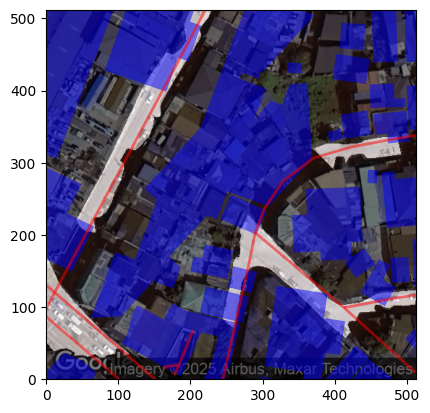

In [196]:
display_patch_mask_overlayed(patch_path, patch_roadlines['geometry_scaled'])

In [150]:
# #get file paths
# #data\roadimages\3 _ Clear Regular Roads\57__14.557001_121.006165.png

# folder_names = ["\\1 _ No Roads", "\\2 _ Roads with Occlusions", "\\3 _ Clear Regular Roads", "\\4 _ Wide Roads"]
# mask_path = str(patch_path).replace("roadimages", "roadmasks")

# #remove folder names from mask paths
# for folder_name in folder_names:
#     mask_path = mask_path.replace(folder_name, "")
# print(mask_path)

# #set patch size
# lat_size = LAT_SIZE/2
# long_size = LONG_SIZE/2
# #right = increase lon offset; up = increase lat offset
# lat_shift = 0.0000
# lon_shift = 0
# random_patch_lat = float(patch_path.stem.split("_")[-2])
# random_patch_lon = float(patch_path.stem.split("_")[-1])

# #adjust linestring coordinates 
# minx, miny, maxx, maxy = (random_patch_lon - long_size, random_patch_lat - lat_size, random_patch_lon + long_size, random_patch_lat + lat_size)
# minx = minx - lon_shift
# maxx = maxx - lon_shift
# miny = miny - lat_shift
# maxy = maxy - lat_shift

# print("Patch Coordinates:", minx, miny, maxx, maxy)
# bbox = sp.geometry.box(minx, miny, maxx, maxy)

# #remove roads outside of patch
# random_patch_roads = dataset_roads.cx[minx:maxx, miny:maxy]

# print("Random patch path:", patch_path)

# image = cv2.imread(str(patch_path))
# mask_image = cv2.imread(str(mask_path))

# if random_patch_roads.empty:
#     print("No roads found in the random patch.")
#     plt.imshow(image)
# else:

#     #show road patch
#     fig, axes = plt.subplots(2, 3, figsize=(15, 7))
#     axes[0][0].imshow(image)

#     #plot linestrings (roadlines)
#     random_patch_roads.plot(ax=axes[0][1])

#     axes[0][1].set_xlim(minx-DISPLAY_ALLOWANCE, maxx+DISPLAY_ALLOWANCE)
#     axes[0][1].set_ylim(miny-DISPLAY_ALLOWANCE, maxy+DISPLAY_ALLOWANCE)
#     axes[0][1].set_aspect('equal')

#     #overlay linestrings on patch
#     axes[0][2].imshow(image, extent=[minx, maxx, miny, maxy])
#     random_patch_roads.plot(ax=axes[0][2], color='red')
#     axes[0][2].set_title("Overlayed Roads on Image")
#     axes[0][2].set_xlim(minx-DISPLAY_ALLOWANCE, maxx+DISPLAY_ALLOWANCE)
#     axes[0][2].set_ylim(miny-DISPLAY_ALLOWANCE, maxy+DISPLAY_ALLOWANCE)
#     axes[0][2].set_aspect('equal')
    
#     #ground truth mask
#     axes[1][1].imshow(mask_image)

#     #overlay linestrings on ground truth mask
#     axes[1][2].imshow(mask_image, extent=[minx, maxx, miny, maxy])
#     random_patch_roads.plot(ax=axes[1][2], color='red')
#     axes[1][2].set_title("Overlayed Roads on Image")
#     axes[1][2].set_xlim(minx, maxx)
#     axes[1][2].set_ylim(miny, maxy)
#     axes[1][2].set_aspect('equal')

#     plt.show()


In [151]:
# #create scaled version of cropped linemap to fit mask
# # Calculate scaling factors
# # Function to scale geometries
# def scale_geometry(geom, x_scale, y_scale):
#     return sp.affinity.scale(geom, xfact=x_scale, yfact=y_scale, origin=(0,0))

# def shift_geometry(geom, x_shift, y_shift):
#     return sp.affinity.translate(geom, xoff=-x_shift, yoff=-y_shift)

# # Create a copy of the GeoDataFrame and apply scaling to the copy
# scaled_patch_roads = random_patch_roads.copy()

# scaled_patch_roads["geometry_scaled"] = scaled_patch_roads["geometry"].apply(
#     lambda geom: shift_geometry(geom, minx, miny)
# )
# scaled_patch_roads["geometry_scaled"] = scaled_patch_roads["geometry_scaled"].apply(
#     lambda geom: scale_geometry(geom, 512/(maxx-minx), 512/(maxy-miny))
# )

# x_shift_initial = minx
# y_shift_initial = miny
# x_scale = 512/(maxx-minx)
# y_scale = 512/(maxy-miny)

# scaled_patch_roads

In [152]:
def get_image_binary_mask(patch_path):
    image_mask_image_path = get_image_mask_image_path(patch_path)
    image = cv2.imread(str(image_mask_image_path), cv2.IMREAD_UNCHANGED)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, image_mask = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return np.flipud(image_mask)

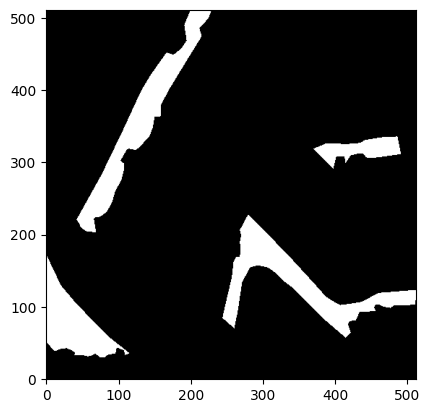

In [153]:
image_mask = get_image_binary_mask(patch_path)
plt.imshow(image_mask, cmap='gray')
plt.gca().invert_yaxis()

In [154]:
def get_roadline_binary_mask(patch_roadlines_scaled):
    roadline_mask = np.zeros((512, 512), dtype=np.uint8)
    for geom in patch_roadlines_scaled:
        if geom.is_empty:
            continue
        if isinstance(geom, sp.LineString):
            coords = np.array(geom.coords, dtype=np.int32)
            cv2.polylines(roadline_mask, [coords], isClosed=False, color=1, thickness=1)
    return roadline_mask

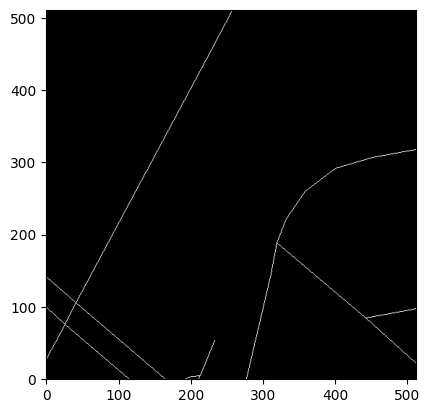

In [155]:
roadline_mask = get_roadline_binary_mask(patch_roadlines['geometry_scaled'])
plt.imshow(roadline_mask, cmap='gray')
plt.gca().invert_yaxis()


In [156]:
def get_intersection(roadline_mask, image_mask):
    return np.sum((roadline_mask > 0) & (image_mask > 0))

def get_best_shift_values(patch_roadlines, image_mask, display=False):
    shifted_roadline_masks = [[None for _ in range(2 * SEARCH_RANGE + 1)] for _ in range(2 * SEARCH_RANGE + 1)]
    for i in range(-SEARCH_RANGE, SEARCH_RANGE + 1):
        for j in range(-SEARCH_RANGE, SEARCH_RANGE + 1):
            road_copy = patch_roadlines['geometry_scaled'].apply(
                lambda geom: shift_geometry(geom, i, j)
            )
            road_mask = get_roadline_binary_mask(road_copy)
            shifted_roadline_masks[i + SEARCH_RANGE][j + SEARCH_RANGE] = road_mask

    max_intersection = -1
    max_i = -1
    max_j = -1

    # Iterate through the shifted_road_masks to find the greatest intersection
    for i in range(2 * SEARCH_RANGE + 1):
        for j in range(2 * SEARCH_RANGE + 1):
            road_mask = shifted_roadline_masks[i][j]
            intersection = get_intersection(road_mask, image_mask)
            if intersection > max_intersection:
                max_intersection = intersection
                max_i = i
                max_j = j

    best_shift_values = (max_i - SEARCH_RANGE, max_j - SEARCH_RANGE)
    best_roadline_mask = shifted_roadline_masks[max_i][max_j]

    if display:
        display_shifted_roadlines(shifted_roadline_masks, image_mask)

    return best_shift_values, best_roadline_mask, max_intersection

def display_shifted_roadlines(shifted_roadline_masks, image_mask):

    fig, axes = plt.subplots(NUM_DISPLAY, NUM_DISPLAY, figsize=(15, 15))
    for i in range(NUM_DISPLAY):
        for j in range(NUM_DISPLAY):
            ax = axes[i, j]
            num = (2 * SEARCH_RANGE)/(NUM_DISPLAY-1)
            i_2 = int(i*num)
            j_2 = int(j*num)
            road_mask = shifted_roadline_masks[i_2][j_2]
            ax.imshow(image_mask, cmap='gray', interpolation='none')
            ax.imshow(road_mask, cmap='Reds', alpha=0.5, interpolation='none')
            ax.set_title(f"({i_2-SEARCH_RANGE},{j_2-SEARCH_RANGE})", fontsize=8)
            ax.axis('off')
            ax.invert_yaxis()
            ax.set_aspect('equal')

    plt.suptitle("Shifted Road Masks Overlayed on Image Mask", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def display_best_shifted_roadlines(best_roadline_mask, image_mask):
    plt.figure(figsize=(10, 10))
    plt.imshow(image_mask, cmap='gray', interpolation='none')
    plt.imshow(best_roadline_mask, cmap='Reds', alpha=0.5, interpolation='none')  # Overlay road_mask in red with transparency
    plt.title("Intersection of Road Mask and Image Mask")
    plt.gca().invert_yaxis()
    plt.show()

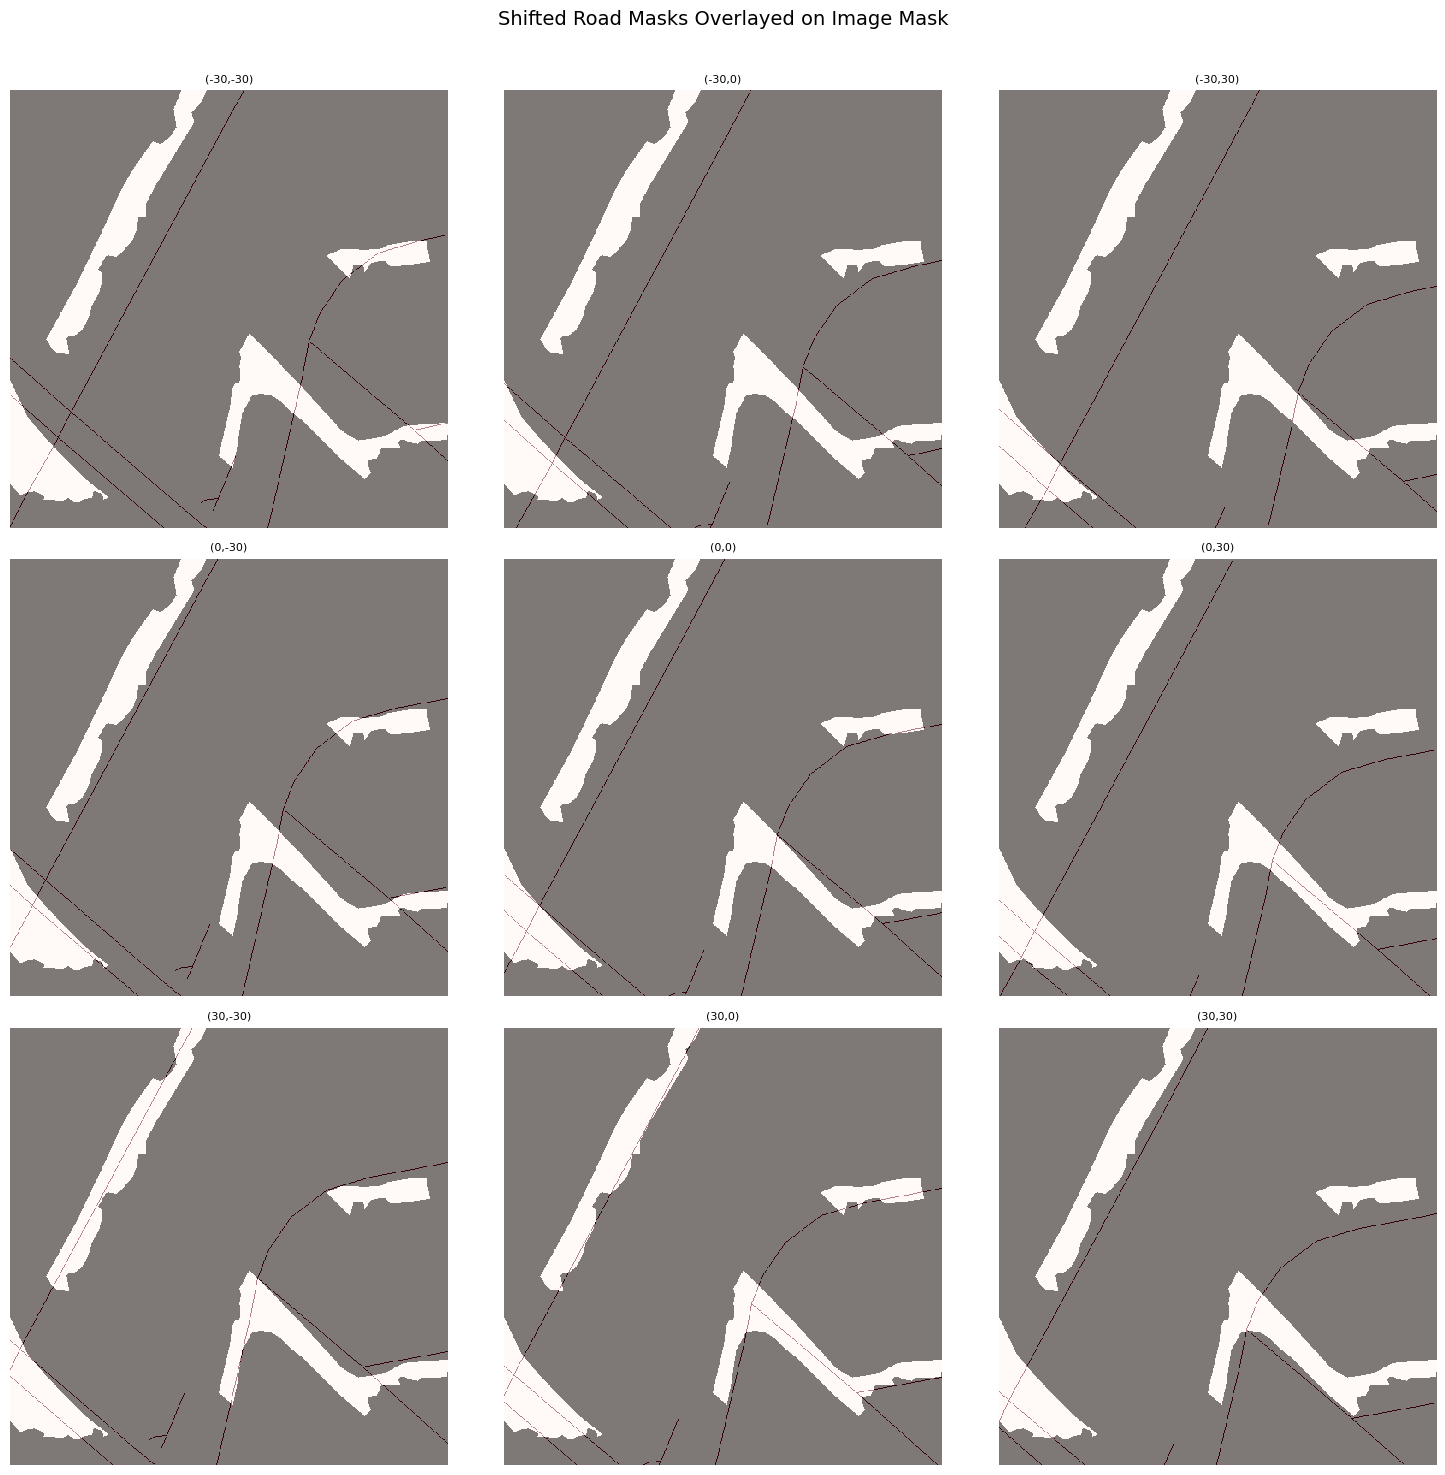

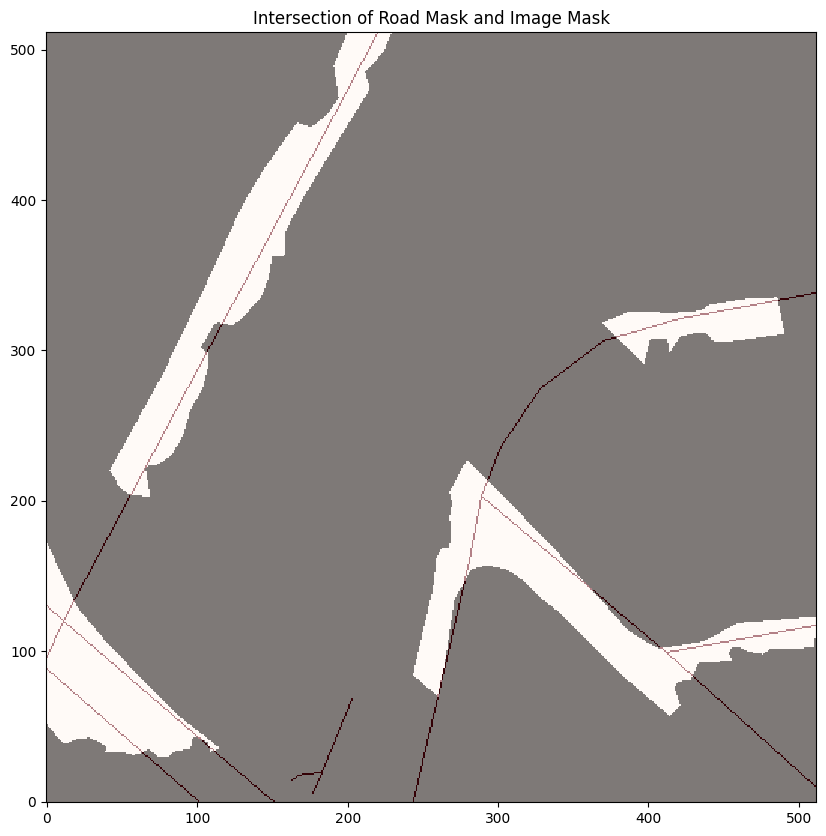

In [157]:
best_shift_values, best_roadline_mask, max_intersection = get_best_shift_values(patch_roadlines, image_mask, True)
display_best_shifted_roadlines(best_roadline_mask, image_mask)

In [158]:
patch_roadlines.loc[:, 'geometry_scaled'] = patch_roadlines['geometry_scaled'].apply(
    lambda geom: shift_geometry(geom, best_shift_values[0], best_shift_values[1])
)

patch_roadlines

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,geometry_scaled
6903,22000401,5122,residential,San Rafael Street,None,B,0,0,F,F,"LINESTRING (121.03027 14.58045, 121.03017 14.5...","LINESTRING (-3.963 90.091, -40.119 24.003, -78..."
6915,22001376,5122,residential,Santo Niño Street,None,B,0,0,F,F,"LINESTRING (121.03309 14.57897, 121.03304 14.5...","LINESTRING (1048.836 -476.197, 1032.082 -453.6..."
6918,22001498,5122,residential,Santa Ana Street,None,B,0,0,F,F,"LINESTRING (121.03284 14.58104, 121.03267 14.5...","LINESTRING (955.216 315.25, 893.463 266.173, 8..."
6919,22001542,5122,residential,San Joaquin Street,None,B,0,0,F,F,"LINESTRING (121.03243 14.58147, 121.03222 14.5...","LINESTRING (804.209 478.152, 723.612 410.685, ..."
550981,616818168,5115,tertiary,San Rafael Street,None,B,0,0,F,F,"LINESTRING (121.03031 14.58053, 121.03027 14.5...","LINESTRING (11.858 120.243, -3.963 90.091)"
617150,680275201,5115,tertiary,San Rafael Street,None,B,0,0,F,F,"LINESTRING (121.03031 14.58053, 121.03081 14.5...","LINESTRING (11.858 120.243, 199.545 471.563)"
638927,695757212,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.03082 14.5804, 121.03077 14.58...","LINESTRING (203.91 68.483, 183.873 19.138, 177..."
638977,695777124,5114,secondary,Boni Avenue,None,F,40,0,F,F,"LINESTRING (121.03089 14.58004, 121.03079 14.5...","LINESTRING (227.045 -68.52, 189.47 -34.116, 16..."
638978,695777126,5114,secondary,Boni Avenue,None,F,40,0,F,F,"LINESTRING (121.03027 14.58045, 121.03073 14.5...","LINESTRING (-3.963 90.091, 168.91 -58.061, 220..."
639018,695881358,5114,secondary,Boni Avenue,None,F,40,0,F,F,"LINESTRING (121.02968 14.58096, 121.02973 14.5...","LINESTRING (-224.373 285.175, -205.119 268.05,..."


In [159]:
def interpolate_points(line, distance_interval):
    length = line.length
    num_points = math.ceil(length / distance_interval)
    distances = [i * distance_interval for i in range(num_points + 1)]
    points = [line.interpolate(distance) for distance in distances]
    #remove points that are out of bounds
    points = [point for point in points if point.x >= 0 and point.x < 512 and point.y >= 0 and point.y < 512]
    return points

In [160]:
def perpendicular_line_eq(line, point):
    coords = list(line.coords)

    for i in range(len(coords) - 1):
        x1, y1 = coords[i]
        x2, y2 = coords[i + 1]
        segment = sp.LineString([(x1, y1), (x2, y2)])

        if segment.distance(point) <= 1e-7:  # Check if point is close to the segment
            # Compute original slope
            if x2 - x1 == 0:  # Vertical line
                return (0, point.y)
            elif y2 - y1 == 0:  # Horizontal line
                return (float('inf'), point.x)
            
            slope = (y2 - y1) / (x2 - x1)
            perp_slope = -1 / slope  # Perpendicular slope

            x, y = point.x, point.y
            b = y - perp_slope * x

            return (perp_slope, b)
    
    return None

In [161]:
#gets point slope pairs of a road line
def compute_points_and_perpendiculars(road_line, distance_interval):
    point_slope_pairs = []
    points = interpolate_points(road_line, distance_interval)
    for point in points:
                perp_result = perpendicular_line_eq(road_line, point)
                if perp_result is not None:
                    slope, intercept = perp_result
                    point_slope_pairs.append((point, slope))
    return point_slope_pairs
    

In [162]:
def clip_patch_roadlines(patch_roadlines):
    bbox = sp.geometry.box(0, 0, 512, 512)
    patch_roadlines.loc[:, 'geometry_scaled'] = patch_roadlines['geometry_scaled'].clip(bbox)
    patch_roadlines.dropna(subset=['geometry_scaled'], inplace=True)

In [163]:
clip_patch_roadlines(patch_roadlines)
patch_roadlines

C:\Users\rafae_ls0opq0\AppData\Local\Temp\ipykernel_6796\3631941680.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_roadlines.dropna(subset=['geometry_scaled'], inplace=True)


,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,geometry_scaled
6915,22001376,5122,residential,Santo Niño Street,None,B,0,0,F,F,"LINESTRING (121.03309 14.57897, 121.03304 14.5...","LINESTRING (512 9.404, 412.754 99.133, 289.582..."
6918,22001498,5122,residential,Santa Ana Street,None,B,0,0,F,F,"LINESTRING (121.03284 14.58104, 121.03267 14.5...","LINESTRING (512 116.654, 478.127 111.508, 412...."
6919,22001542,5122,residential,San Joaquin Street,None,B,0,0,F,F,"LINESTRING (121.03243 14.58147, 121.03222 14.5...","LINESTRING (512 337.928, 470.851 330.92, 421.4..."
550981,616818168,5115,tertiary,San Rafael Street,None,B,0,0,F,F,"LINESTRING (121.03031 14.58053, 121.03027 14.5...","LINESTRING (11.858 120.243, 0 97.643)"
617150,680275201,5115,tertiary,San Rafael Street,None,B,0,0,F,F,"LINESTRING (121.03031 14.58053, 121.03081 14.5...","LINESTRING (11.858 120.243, 199.545 471.563)"
638927,695757212,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.03082 14.5804, 121.03077 14.58...","LINESTRING (203.91 68.483, 183.873 19.138, 177..."
638977,695777124,5114,secondary,Boni Avenue,None,F,40,0,F,F,"LINESTRING (121.03089 14.58004, 121.03079 14.5...","LINESTRING (151.262 0, 149.769 1.284, 11.858 1..."
638978,695777126,5114,secondary,Boni Avenue,None,F,40,0,F,F,"LINESTRING (121.03027 14.58045, 121.03073 14.5...","LINESTRING (0 86.695, 101.161 0)"
715637,771352867,5114,secondary,Boni Avenue,None,F,40,0,F,F,"LINESTRING (121.03031 14.58053, 121.02999 14.5...","LINESTRING (11.858 120.243, 0 130.535)"
719505,776324539,5115,tertiary,San Rafael Street,None,B,0,0,F,F,"LINESTRING (121.03081 14.58145, 121.03098 14.5...","LINESTRING (199.545 471.563, 220.569 512)"


In [164]:
def display_interpolated_points(patch_roadlines):
    for road in patch_roadlines['geometry_scaled'].items():
        geom = road[1]
        
        if isinstance(geom, sp.MultiLineString):
            for line in geom.geoms:
                # Plot the line being interpolated
                x, y = line.xy
                plt.plot(x, y, color='black', linewidth=1, alpha=0.7)
                point_slope_pairs = compute_points_and_perpendiculars(line, SEARCH_INTERVAL)
                for point_slope_pair in point_slope_pairs:
                    point, slope = point_slope_pair
                    plt.scatter(point.x, point.y, color='blue', s=20)
        elif isinstance(geom, sp.LineString):
            x, y = geom.xy
            plt.plot(x, y, color='black', linewidth=1, alpha=0.7)
            point_slope_pairs = compute_points_and_perpendiculars(geom, SEARCH_INTERVAL)
            for point_slope_pair in point_slope_pairs:
                point, slope = point_slope_pair
                point, slope = point_slope_pair
                plt.scatter(point.x, point.y, color='blue', s=20)

    plt.xlim(0, 512)
    plt.ylim(0, 512)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

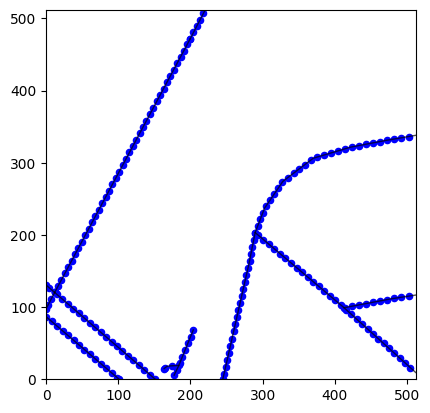

In [165]:
display_interpolated_points(patch_roadlines)

In [166]:
def graph_measurements(points_forward, points_backward, image_mask, point, returned_distance=None):
    plt.imshow(image_mask, cmap='gray')
    x, y = int(point.x), int(point.y)
    plt.scatter(x, y, color='red', label='Start Point', edgecolors='black', marker='o')
    if points_forward:
        plt.scatter(*zip(*points_forward), color='blue', label='Forward Boundary', edgecolors='black', marker='x')
    if points_backward:
        plt.scatter(*zip(*points_backward), color='green', label='Backward Boundary', edgecolors='black', marker='s')
    plt.gca().invert_yaxis()
    plt.legend()

    if(returned_distance is not None):
        if returned_distance == "forward":
            x_vals = [points_forward[0][0], points_forward[1][0]]
            y_vals = [points_forward[0][1], points_forward[1][1]]
        elif returned_distance == "backward":
            x_vals = [points_backward[0][0], points_backward[1][0]]
            y_vals = [points_backward[0][1], points_backward[1][1]]
        elif returned_distance == "inside":
            x_vals = [points_forward[0][0], points_backward[0][0]]
            y_vals = [points_forward[0][1], points_backward[0][1]]
        plt.plot(x_vals, y_vals, color='orange', linewidth=2, label='Width Line')
    plt.show()

In [167]:
def measure_nearest_road_to_point(point, slope, image_mask, plot=True):
    min_distance = 2
    x, y = int(point.x), int(point.y)
    width, height = image_mask.shape  # Fix: Ensure correct order (height, width)

    # Check if the point is inside the image bounds
    if not (0 <= x < width and 0 <= y < height):
        return None  # Ensure point is within bounds

    search_mode = "inside" if image_mask[y, x] == 255 else "outside"
    points_forward = []
    points_backward = []

    if slope == float('inf'):  # **Vertical case**
        # Move upward (-y direction)
        found_white = False
        for i in range(y - 1, -1, -1):
            if search_mode == "inside" and (image_mask[i, x] == 0 or i == 0 or i == height - 1):
                points_backward.append((x, i))
                break
            if search_mode == "outside":
                if image_mask[i, x] == 255 and not found_white:
                    points_backward.append((x, i))
                    found_white = True
                    continue
                if found_white and image_mask[i, x] == 0:
                    points_backward.append((x, i))
                    break

        # Move downward (+y direction)
        found_white = False
        for i in range(y + 1, height):
            if search_mode == "inside" and (image_mask[i, x] == 0 or i == 0 or i == height - 1):
                points_forward.append((x, i))
                break
            if search_mode == "outside":
                if image_mask[i, x] == 255 and not found_white:
                    points_forward.append((x, i))
                    found_white = True
                    continue
                if found_white and image_mask[i, x] == 0:
                    points_forward.append((x, i))
                    break

    else:  # **Non-vertical case (diagonal/horizontal)**
        step_size = 1 / max(abs(slope), 1)  # Normalize step size
        dx = step_size if slope >= 0 else -step_size
        dy = slope * dx

        # Move forward
        xi, yi = x + dx, y + dy
        found_white = False
        while 0 <= int(round(xi)) < width and 0 <= int(round(yi)) < height:
            if search_mode == "inside" and (image_mask[int(round(yi)), int(round(xi))] == 0 or int(round(xi)) == 0 or int(round(xi)) == width - 1 or int(round(yi)) == 0 or int(round(yi)) == height - 1):
                points_forward.append((int(round(xi)), int(round(yi))))
                break
            if search_mode == "outside":
                if image_mask[int(round(yi)), int(round(xi))] == 255 and not found_white:
                    points_forward.append((int(round(xi)), int(round(yi))))
                    found_white = True
                    xi += dx
                    yi += dy
                    continue
                if found_white and image_mask[int(round(yi)), int(round(xi))] == 0:
                    points_forward.append((int(round(xi)), int(round(yi))))
                    break
            xi += dx
            yi += dy

        # Move backward
        xi, yi = x - dx, y - dy
        found_white = False
        while 0 <= int(round(xi)) < width and 0 <= int(round(yi)) < height:
            if search_mode == "inside" and (image_mask[int(round(yi)), int(round(xi))] == 0 or int(round(xi)) == 0 or int(round(xi)) == width - 1 or int(round(yi)) == 0 or int(round(yi)) == height - 1):
                points_backward.append((int(round(xi)), int(round(yi))))
                break
            if search_mode == "outside":
                if image_mask[int(round(yi)), int(round(xi))] == 255 and not found_white:
                    points_backward.append((int(round(xi)), int(round(yi))))
                    found_white = True
                    xi -= dx
                    yi -= dy
                    continue
                if found_white and image_mask[int(round(yi)), int(round(xi))] == 0:
                    points_backward.append((int(round(xi)), int(round(yi))))
                    break
            xi -= dx
            yi -= dy

    # **Return total measured width**
    returned_distance = None
    returned_value = None

    if search_mode == "inside":
        if points_forward and points_backward:
            total_dist = math.dist((point.x, point.y), points_forward[0]) + math.dist((point.x, point.y), points_backward[0])
            if total_dist > MAX_ROAD_WIDTH:
                return None
            returned_value = total_dist
            returned_distance = "inside"
    else:
        forward_dist = math.dist(points_forward[0], points_forward[1]) if len(points_forward) > 1 else None
        backward_dist = math.dist(points_backward[0], points_backward[1]) if len(points_backward) > 1 else None
        if forward_dist is not None and forward_dist > MAX_ROAD_WIDTH:
            forward_dist = None
        if backward_dist is not None and backward_dist > MAX_ROAD_WIDTH:
            backward_dist = None

        if forward_dist is not None and backward_dist is not None:
            if math.dist((point.x, point.y), points_forward[0]) < math.dist((point.x, point.y), points_backward[0]) and math.dist((point.x, point.y), points_forward[0]) < MAX_DISTANCE_FROM_ROAD and forward_dist > 1.1:
                returned_value = forward_dist
                returned_distance = "forward"
            elif math.dist((point.x, point.y), points_backward[0]) < MAX_DISTANCE_FROM_ROAD and backward_dist > 1.1:
                returned_value = backward_dist
                returned_distance = "backward"
        elif forward_dist is not None and forward_dist > 1.1 and math.dist((point.x, point.y), points_forward[0]) < MAX_DISTANCE_FROM_ROAD:
            returned_value = forward_dist
            returned_distance = "forward"
        elif backward_dist is not None and backward_dist > 1.1 and math.dist((point.x, point.y), points_backward[0]) < MAX_DISTANCE_FROM_ROAD:
            returned_value = backward_dist
            returned_distance = "backward"

    if plot:
        graph_measurements(points_forward, points_backward, image_mask, point, returned_distance)

    return returned_value

In [168]:
def convert_coords(point_i):
    point = shift_geometry(point_i, -best_shift_values[0], -best_shift_values[1])
    point = scale_geometry(point, (patch_bounds['max_lon']-patch_bounds['min_lon'])/PATCH_SIZE, (patch_bounds['max_lat']-patch_bounds['min_lat'])/PATCH_SIZE)
    point = shift_geometry(point, -patch_bounds['min_lon'], -patch_bounds['min_lat'])
    return point

In [169]:
test = patch_roadlines.copy()
print(test["geometry"].iloc[0])
point = sp.Point(test["geometry_scaled"].iloc[0].coords[1])
print(point)
print(convert_coords(point))

LINESTRING (121.0330892 14.5789747, 121.0330443 14.5790335, 121.0318851 14.5800356, 121.0313845 14.5804764, 121.0310544 14.5807481)
POINT (412.753731345296 99.13289434282021)
POINT (121.0313845 14.5804764)


In [170]:
#get width measurements of one road line
def measure_road_width(line,  image_mask, plot=False):
    point_slope_pairs = compute_points_and_perpendiculars(line, SEARCH_INTERVAL)
    widths = []
    for point_slope_pair in point_slope_pairs:
        point, slope = point_slope_pair
        width = measure_nearest_road_to_point((point), slope, image_mask, plot=plot)
        coords = convert_coords(point)
        if width is not None:
            widths.append((point_slope_pair, coords, width))
    return widths

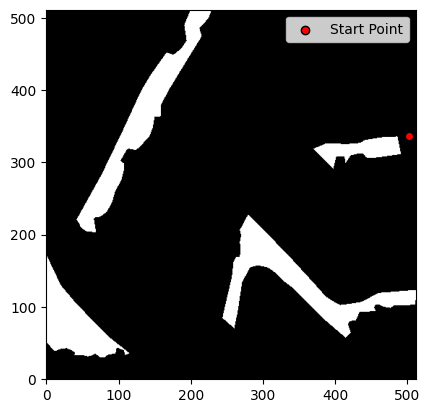

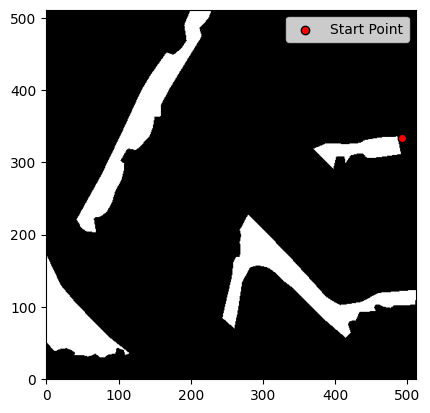

C:\Users\rafae_ls0opq0\AppData\Local\Temp\ipykernel_6796\2575040778.py:6: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(*zip(*points_forward), color='blue', label='Forward Boundary', edgecolors='black', marker='x')


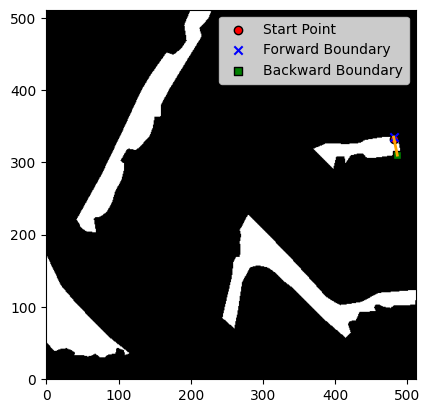

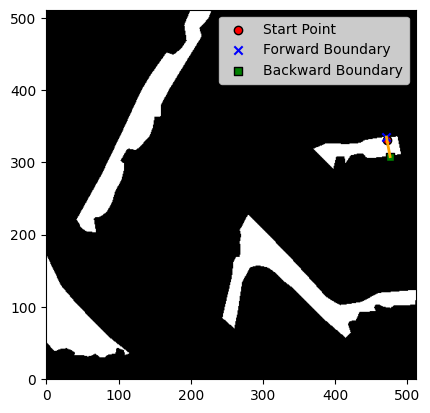

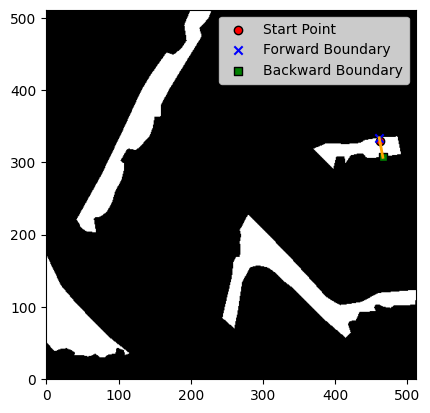

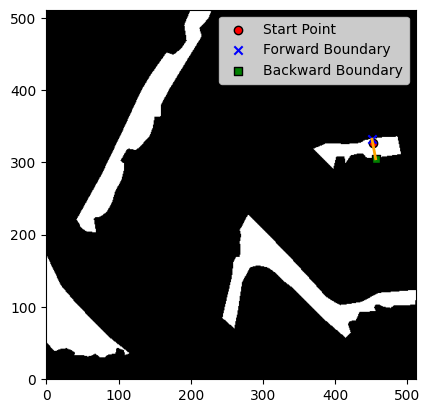

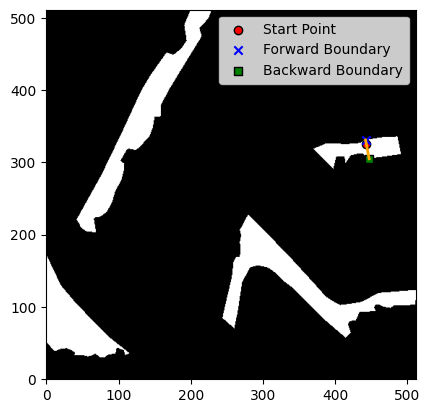

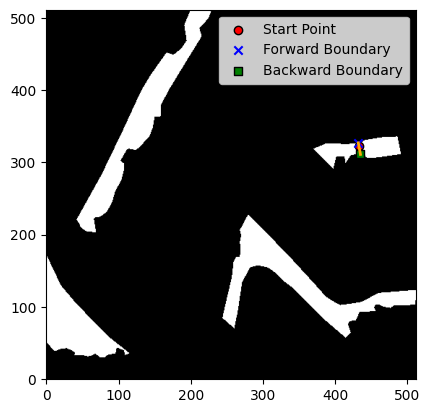

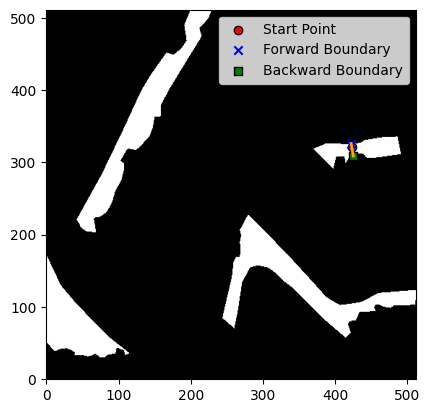

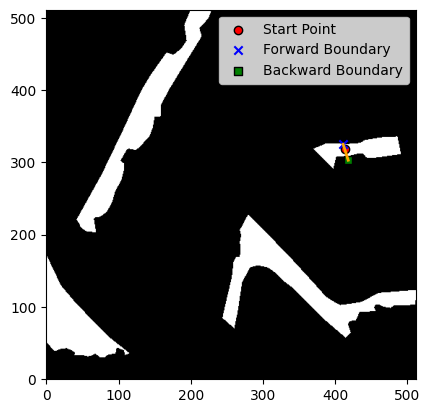

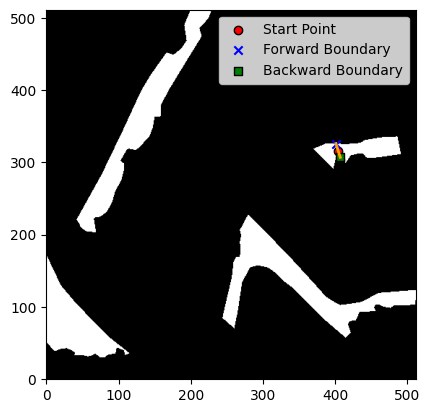

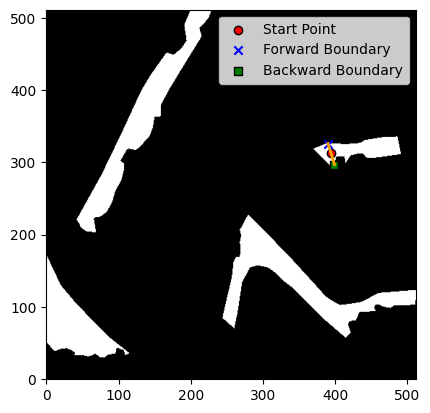

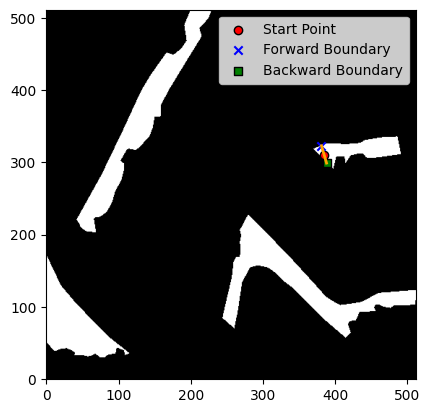

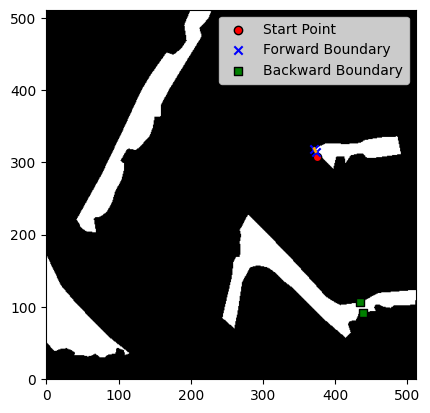

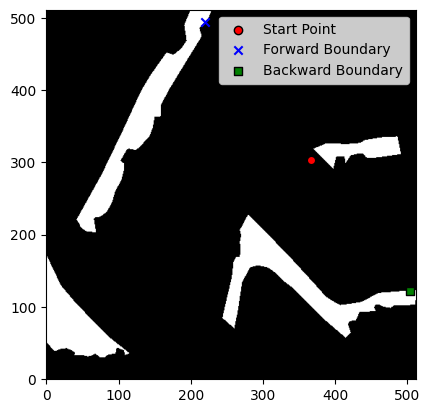

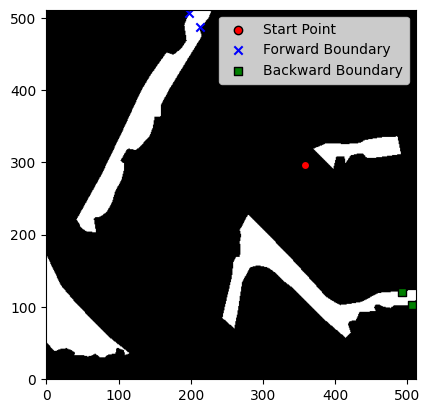

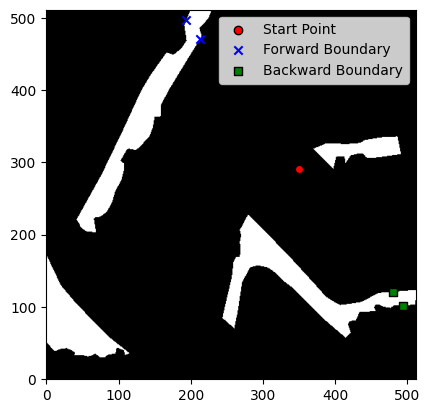

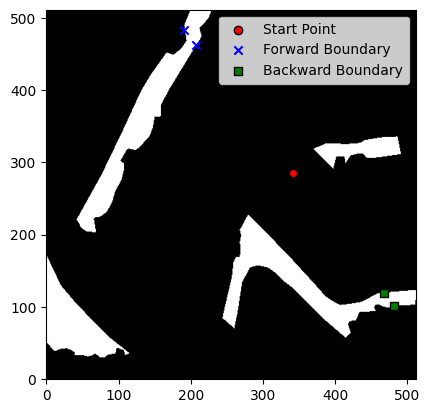

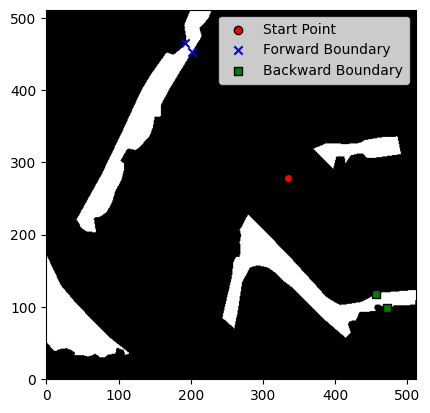

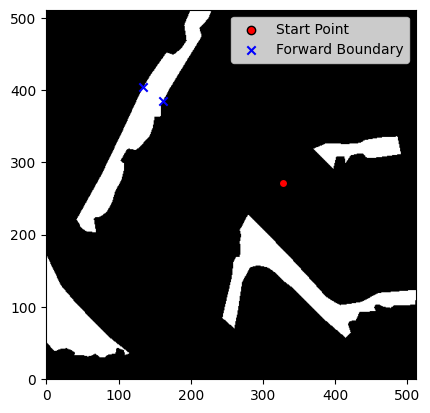

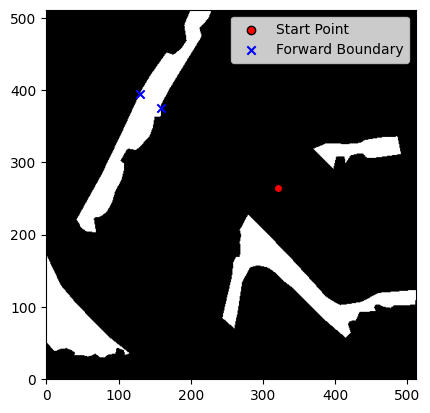

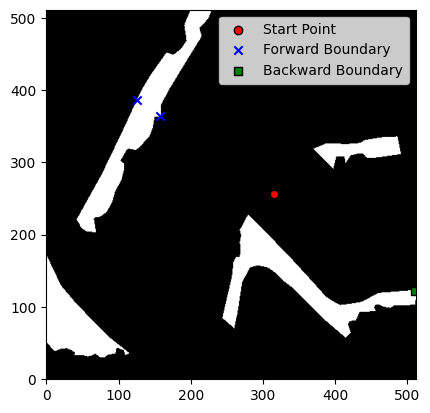

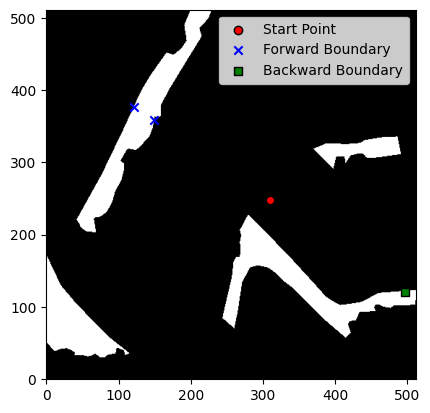

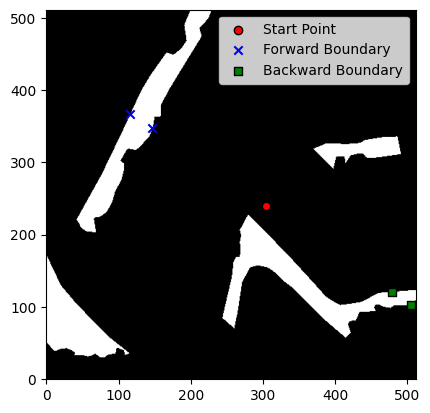

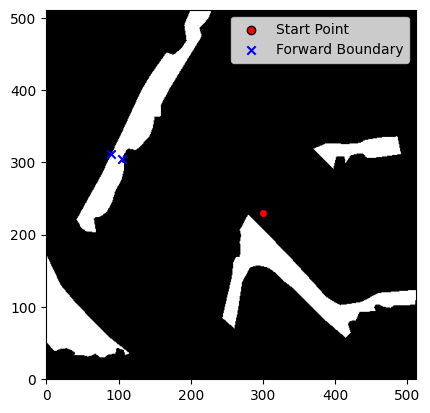

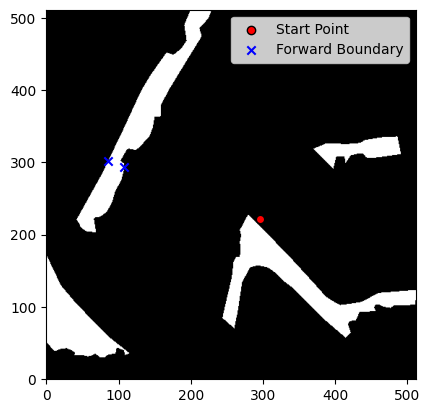

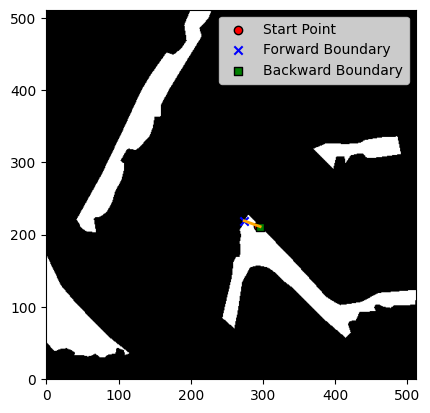

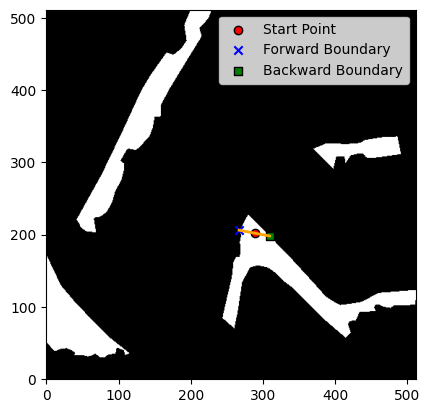

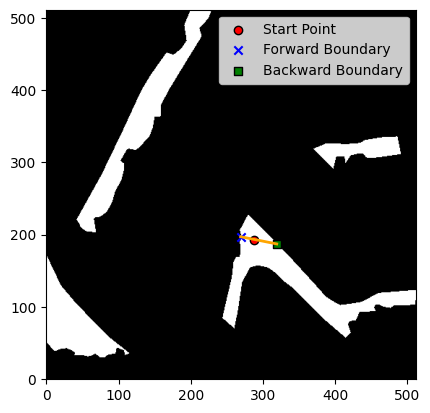

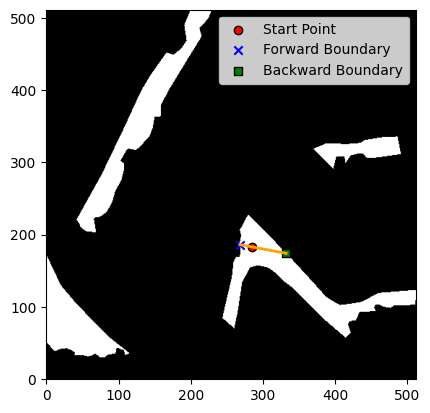

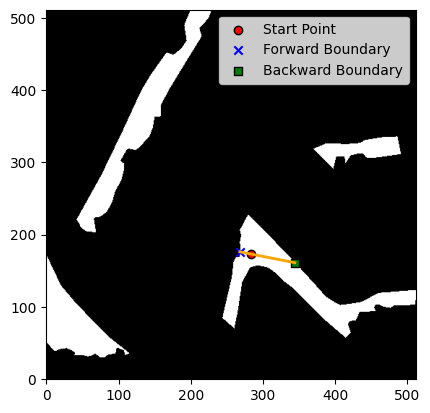

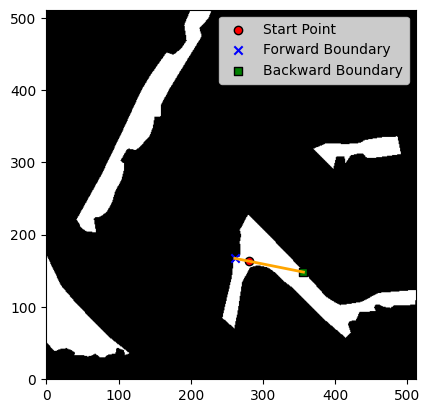

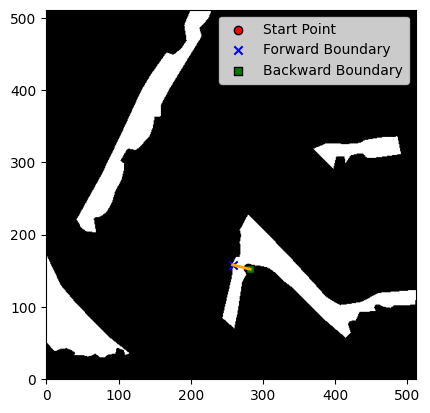

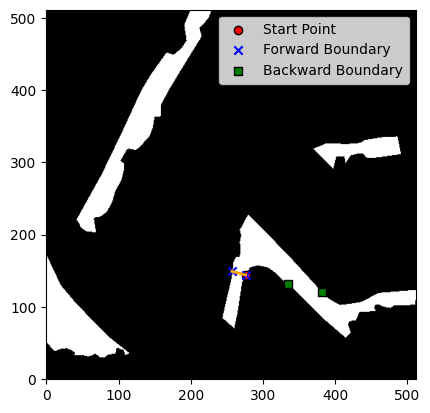

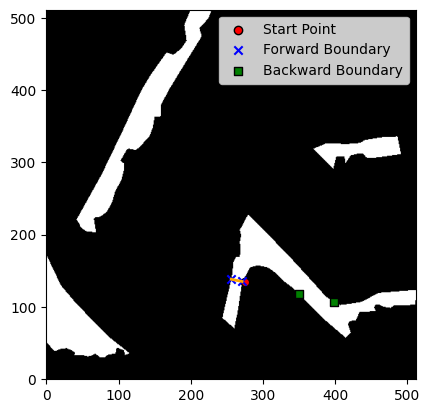

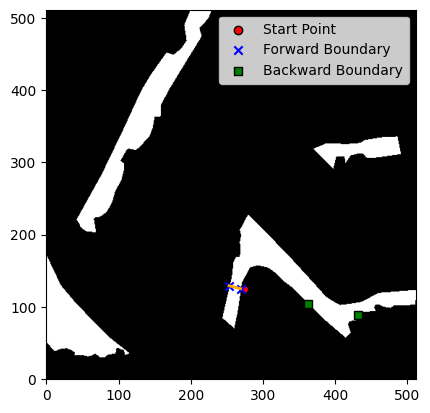

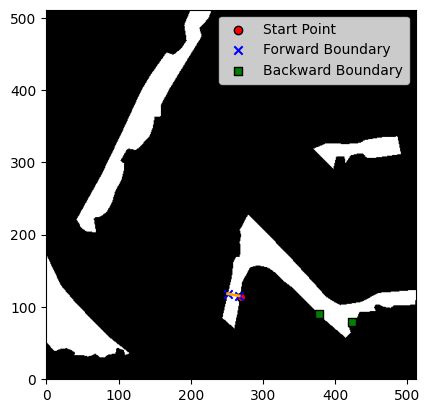

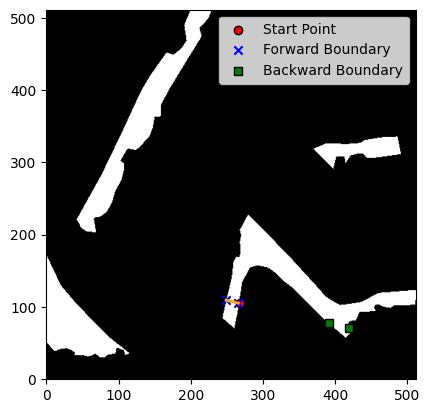

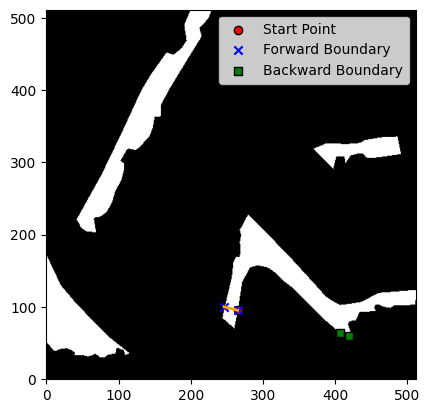

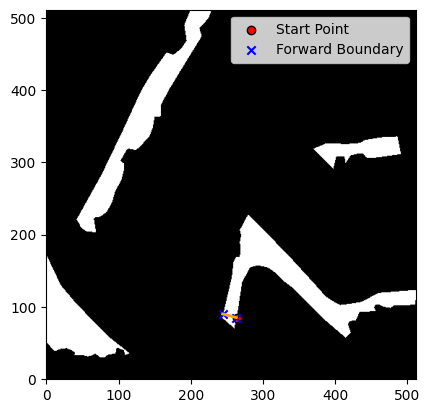

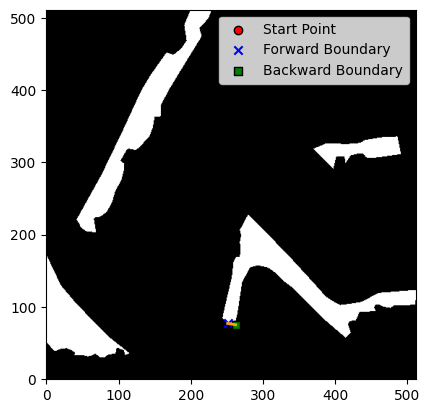

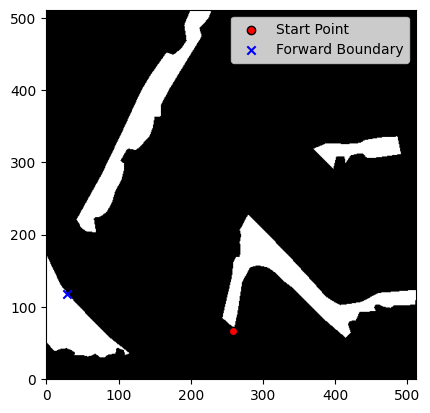

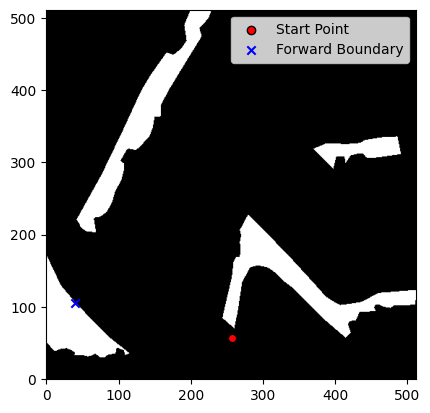

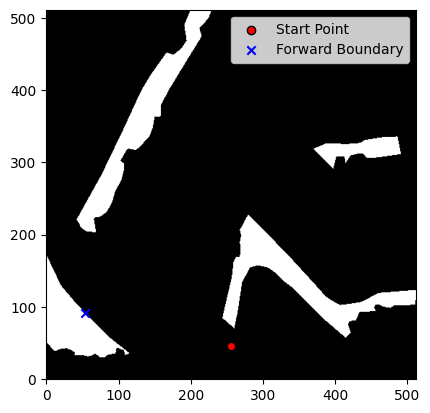

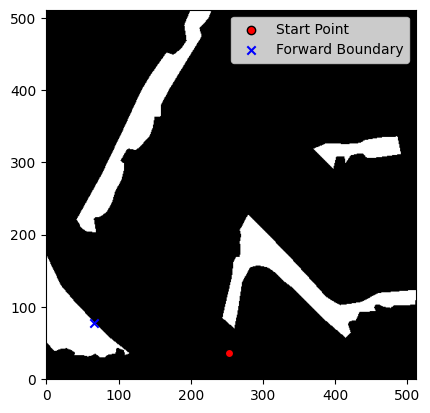

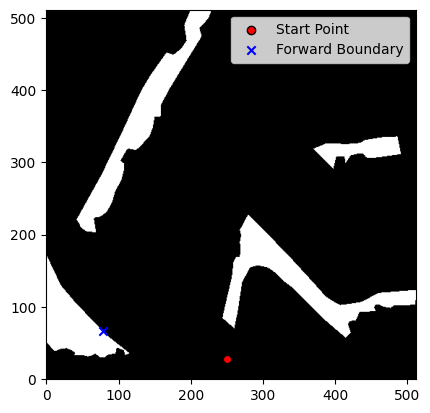

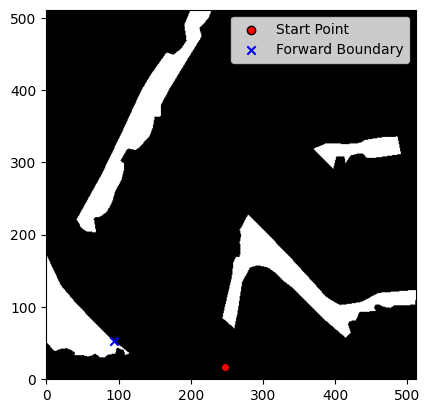

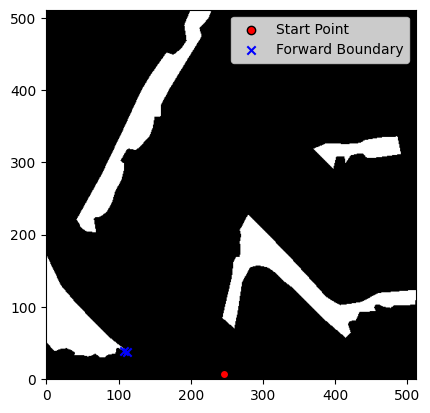

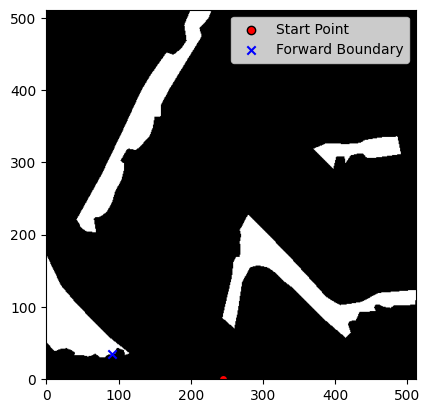

Average road width: 29.25 pixels


In [171]:
instance = patch_roadlines.iloc[2]
geom = instance['geometry_scaled']

widths = []

if isinstance(geom, sp.MultiLineString):
    for line in geom.geoms:
        widths = measure_road_width(line, image_mask, True)
elif isinstance(geom, sp.LineString):
    widths = measure_road_width(geom, image_mask, True)

average_width = np.mean([width for _, _, width in widths])
print(f"Average road width: {average_width:.2f} pixels")

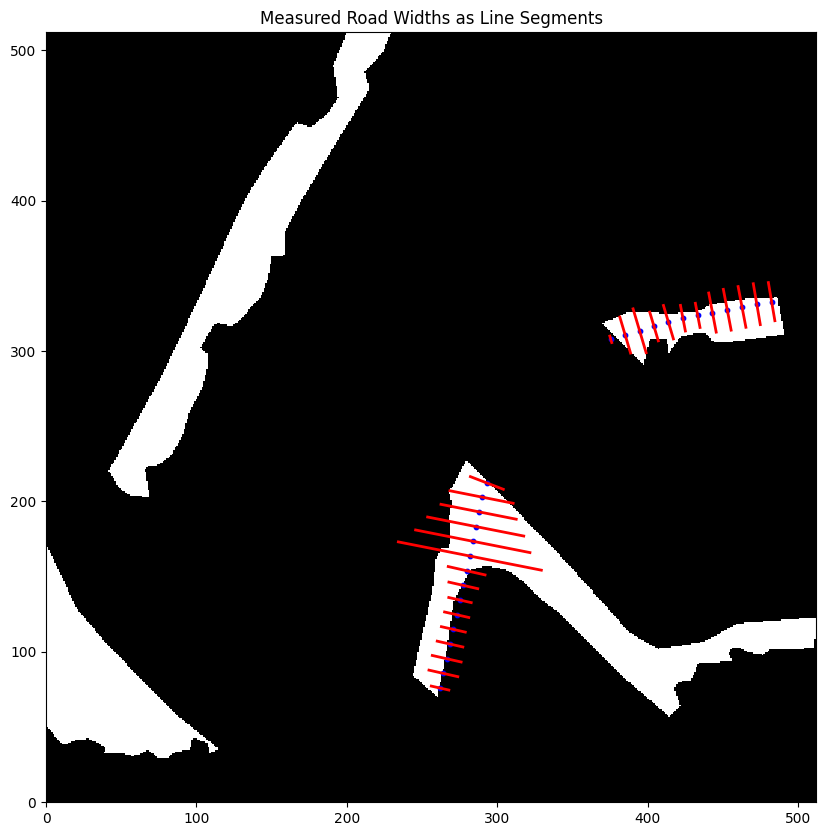

In [172]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_mask, cmap='gray', interpolation='none')

for width_info in widths:
    (point, slope), coords, width = width_info
    x0, y0 = point.x, point.y

    # Calculate dx, dy for the perpendicular line segment
    if slope == float('inf'):
        dx, dy = 0, width / 2
    elif slope == 0:
        dx, dy = width / 2, 0
    else:
        dx = (width / 2) / (1 + slope ** 2) ** 0.5
        dy = slope * dx 

    # Endpoints of the width segment
    x1, y1 = x0 - dx, y0 - dy
    x2, y2 = x0 + dx, y0 + dy

    ax.plot([x1, x2], [y1, y2], color='red', linewidth=2)
    ax.scatter([x0], [y0], color='blue', s=10)  # Mark the center point

ax.set_xlim(0, 512)
ax.set_ylim(0, 512)
ax.set_aspect('equal')
ax.set_title("Measured Road Widths as Line Segments")
plt.show()

In [173]:
def get_patch_road_widths(roads, image_mask):
    road_widths = []
    for road in roads.itertuples():
        geom = road.geometry_scaled
        osm_id = road.osm_id
        if isinstance(geom, sp.MultiLineString):
            for line in geom.geoms:
                widths = measure_road_width(line, image_mask)
                road_widths.append((osm_id, widths))
        elif isinstance(geom, sp.LineString):
            widths = measure_road_width(geom, image_mask)
            road_widths.append((osm_id, widths))
    return road_widths

In [174]:
def get_patch_road_widths_df(roads, image_mask):
    road_widths = []
    for road in roads.itertuples():
        geom = road.geometry_scaled
        osm_id = road.osm_id
        if isinstance(geom, sp.MultiLineString):
            for line in geom.geoms:
                widths = measure_road_width(line, image_mask)
                for point_slope_pair, coords, width in widths:
                    point, slope = point_slope_pair
                    road_widths.append({
                        'osm_id': osm_id,
                        'coordinates_on_image': point,
                        'map_coordinates': coords,
                        'slope': slope,
                        'width': width
                    })
        elif isinstance(geom, sp.LineString):
            widths = measure_road_width(geom, image_mask)
            for point_slope_pair, coords, width in widths:
                point, slope = point_slope_pair
                road_widths.append({
                    'osm_id': osm_id,
                    'coordinates_on_image': point,
                    'map_coordinates': coords,
                    'slope': slope,
                    'width': width
                })
    return pd.DataFrame(road_widths)


In [175]:
patch_road_widths = get_patch_road_widths(patch_roadlines, image_mask)
patch_road_widths

[('22001376',
  [((<POINT (445.24 69.762)>, 1.106065818888289),
    <POINT (121.031 14.58)>,
    31.144823004794873),
   ((<POINT (437.822 76.468)>, 1.106065818888289),
    <POINT (121.031 14.58)>,
    2.8284271247461903),
   ((<POINT (430.404 83.175)>, 1.106065818888289),
    <POINT (121.031 14.58)>,
    1.4142135623730951),
   ((<POINT (422.987 89.881)>, 1.106065818888289),
    <POINT (121.031 14.58)>,
    55.22911676971442),
   ((<POINT (415.569 96.588)>, 1.106065818888289),
    <POINT (121.031 14.58)>,
    41.775749812617434),
   ((<POINT (408.015 103.138)>, 1.1832802011293535),
    <POINT (121.031 14.58)>,
    28.42534080710379),
   ((<POINT (400.377 109.593)>, 1.1832802011293535),
    <POINT (121.031 14.581)>,
    27.018512172212592),
   ((<POINT (392.739 116.048)>, 1.1832802011293535),
    <POINT (121.031 14.581)>,
    24.839484696748443),
   ((<POINT (385.101 122.502)>, 1.1832802011293535),
    <POINT (121.031 14.581)>,
    24.08318915758459),
   ((<POINT (377.463 128.957)>, 1.

In [176]:
patch_road_widths_df = get_patch_road_widths_df(patch_roadlines, image_mask)
patch_road_widths_df

,osm_id,coordinates_on_image,map_coordinates,slope,width
0,22001376,POINT (445.2399770015468 69.76190655756994),POINT (121.03147156313835 14.580399737132664),1.106066,31.144823
1,22001376,POINT (437.8221966683853 76.46836127887859),POINT (121.03145168348706 14.58041724202737),1.106066,2.828427
2,22001376,POINT (430.4044163352238 83.17481600018722),POINT (121.03143180383577 14.580434746922077),1.106066,1.414214
3,22001376,POINT (422.98663600206237 89.88127072149587),POINT (121.03141192418448 14.580452251816782),1.106066,55.229117
4,22001376,POINT (415.5688556689009 96.5877254428045),POINT (121.03139204453319 14.580469756711489),1.106066,41.775750
...,...,...,...,...,...
124,776324539,POINT (199.54477612021867 471.5627057767392),POINT (121.0308131 14.5814485),-0.519927,19.328136
125,776324539,POINT (204.15779296002293 480.4351392442656),POINT (121.03082546288513 14.581471658437668),-0.519927,27.312699
126,776324539,POINT (208.77080979982716 489.30757271179203),POINT (121.03083782577026 14.581494816875336),-0.519927,22.915841
127,776324539,POINT (213.38382663963142 498.1800061793184),POINT (121.03085018865539 14.581517975313004),-0.519927,26.842235


In [177]:
def generate_width_statistics(patch_road_widths_df):
    width_stats = patch_road_widths_df.groupby('osm_id')['width'].describe()
    return width_stats

In [178]:
width_statistics = generate_width_statistics(patch_road_widths_df)
width_statistics

,count,mean,std,min,25%,50%,75%,max
osm_id,,,,,,,,
22001376,22.0,36.024909,21.644916,1.414214,26.441235,30.484975,41.094856,95.790138
22001498,11.0,22.623355,7.765858,14.374690,18.296955,21.213209,23.514241,42.887270
22001542,27.0,29.254588,20.785785,4.472136,17.402120,23.420103,27.582630,96.904474
616818168,3.0,72.653651,26.032189,47.421584,59.271351,71.121118,85.269685,99.418251
680275201,33.0,29.476745,7.552282,14.764823,26.440261,30.947711,34.003266,48.778600
695777124,14.0,43.521182,18.949424,2.828427,31.543104,45.725859,54.972093,68.767888
695777126,12.0,42.188490,23.574156,1.414214,27.116736,50.330957,56.385024,68.771297
771352867,2.0,27.671230,3.977880,24.858445,26.264837,27.671230,29.077623,30.484016
776324539,5.0,22.956314,4.128017,18.382661,19.328136,22.915841,26.842235,27.312699


In [179]:
#calculate m per pixel: https://wiki.openstreetmap.org/wiki/Zoom_levels
def meters_per_pixel(lat):
    return EARTH_CIRCUFERENCE * abs(math.cos(math.radians(lat))) / (512 * (2 ** 18))

In [180]:
combined_data = dataset_footprints
combined_data

0        MULTIPOLYGON (((121.0309 14.56083, 121.03087 1...
1        MULTIPOLYGON (((121.02055 14.55521, 121.02055 ...
2        MULTIPOLYGON (((121.02418 14.54927, 121.02427 ...
3        MULTIPOLYGON (((121.02705 14.5628, 121.02705 1...
4        MULTIPOLYGON (((121.01556 14.5394, 121.01552 1...
                               ...                        
64642    MULTIPOLYGON (((121.03674 14.58929, 121.03682 ...
64643    MULTIPOLYGON (((121.02996 14.59323, 121.03002 ...
64644    MULTIPOLYGON (((121.04242 14.58867, 121.04218 ...
64645    MULTIPOLYGON (((121.0449 14.5879, 121.04547 14...
64646    MULTIPOLYGON (((121.04527 14.58734, 121.04529 ...
Name: geometry, Length: 64647, dtype: geometry

<Axes: >

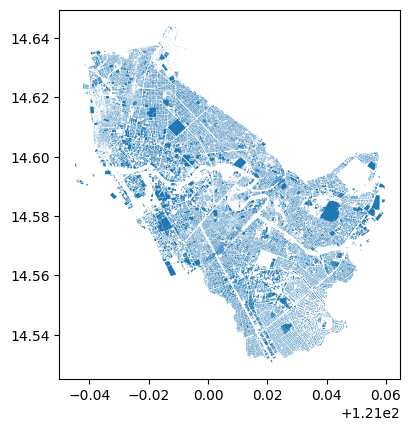

In [181]:
combined_data.plot()

In [182]:
#get file paths
#data\roadimages\3 _ Clear Regular Roads\57__14.557001_121.006165.png
DISPLAY_ALLOWANCE = 0.0000

random_patch_path = random.choice(file_paths)
#random_patch_path = Path("data\\roadmasks\\30__14.554343_121.002045.png")
#random_patch_path = Path("data\\roadmasks\\70__14.598202_121.051483.png")
random_patch_path = Path("data\\roadmasks\\13__14.580925_121.030884.png")
folder_names = ["\\1 _ No Roads", "\\2 _ Roads with Occlusions", "\\3 _ Clear Regular Roads", "\\4 _ Wide Roads"]
mask_path = str(random_patch_path).replace("roadimages", "roadmasks")

#remove folder names from mask paths
for folder_name in folder_names:
    mask_path = mask_path.replace(folder_name, "")
print(mask_path)

#set patch size
lat_size = LAT_SIZE/2
long_size = LONG_SIZE/2
#right = increase lon offset; up = increase lat offset
lat_shift = 0.0000
lon_shift = -0.000053
random_patch_lat = float(random_patch_path.stem.split("_")[-2])
random_patch_lon = float(random_patch_path.stem.split("_")[-1])

#adjust linestring coordinates 
minx, miny, maxx, maxy = (random_patch_lon - long_size, random_patch_lat - lat_size, random_patch_lon + long_size, random_patch_lat + lat_size)
minx = minx - lon_shift
maxx = maxx - lon_shift
miny = miny - lat_shift
maxy = maxy - lat_shift
bbox = sp.geometry.box(minx, miny, maxx, maxy)

area_roads = combined_data.cx[minx:maxx, miny:maxy]
area_roads

data\roadmasks\13__14.580925_121.030884.png


54522    MULTIPOLYGON (((121.0321 14.5813, 121.03198 14...
54910    MULTIPOLYGON (((121.03158 14.58132, 121.03158 ...
55022    MULTIPOLYGON (((121.03078 14.58069, 121.03079 ...
55204    MULTIPOLYGON (((121.03153 14.58127, 121.03153 ...
55303    MULTIPOLYGON (((121.03134 14.58069, 121.03122 ...
55626    MULTIPOLYGON (((121.02989 14.58096, 121.02994 ...
55769    MULTIPOLYGON (((121.03128 14.58143, 121.0314 1...
55851    MULTIPOLYGON (((121.03129 14.58145, 121.03129 ...
56011    MULTIPOLYGON (((121.03141 14.5814, 121.03141 1...
56012    MULTIPOLYGON (((121.03143 14.58101, 121.03143 ...
56120    MULTIPOLYGON (((121.03101 14.5803, 121.03105 1...
56246    MULTIPOLYGON (((121.03093 14.58046, 121.03077 ...
56502    MULTIPOLYGON (((121.03096 14.58057, 121.03087 ...
56529    MULTIPOLYGON (((121.03135 14.58062, 121.03131 ...
56620    MULTIPOLYGON (((121.03164 14.58132, 121.03165 ...
56838    MULTIPOLYGON (((121.03154 14.5807, 121.03155 1...
57026    MULTIPOLYGON (((121.0315 14.58059, 121.03146 1.

In [183]:
print("Min X:", minx)
print("Min Y:", miny)
print("Max X:", maxx)
print("Max Y:", maxy)

Min X: 121.03025092
Min Y: 14.5802568
Max X: 121.03162307999999
Max Y: 14.5815932


In [184]:
area_roads = combined_data.cx[minx:maxx, miny:maxy]
area_roads

54522    MULTIPOLYGON (((121.0321 14.5813, 121.03198 14...
54910    MULTIPOLYGON (((121.03158 14.58132, 121.03158 ...
55022    MULTIPOLYGON (((121.03078 14.58069, 121.03079 ...
55204    MULTIPOLYGON (((121.03153 14.58127, 121.03153 ...
55303    MULTIPOLYGON (((121.03134 14.58069, 121.03122 ...
55626    MULTIPOLYGON (((121.02989 14.58096, 121.02994 ...
55769    MULTIPOLYGON (((121.03128 14.58143, 121.0314 1...
55851    MULTIPOLYGON (((121.03129 14.58145, 121.03129 ...
56011    MULTIPOLYGON (((121.03141 14.5814, 121.03141 1...
56012    MULTIPOLYGON (((121.03143 14.58101, 121.03143 ...
56120    MULTIPOLYGON (((121.03101 14.5803, 121.03105 1...
56246    MULTIPOLYGON (((121.03093 14.58046, 121.03077 ...
56502    MULTIPOLYGON (((121.03096 14.58057, 121.03087 ...
56529    MULTIPOLYGON (((121.03135 14.58062, 121.03131 ...
56620    MULTIPOLYGON (((121.03164 14.58132, 121.03165 ...
56838    MULTIPOLYGON (((121.03154 14.5807, 121.03155 1...
57026    MULTIPOLYGON (((121.0315 14.58059, 121.03146 1.

<Axes: >

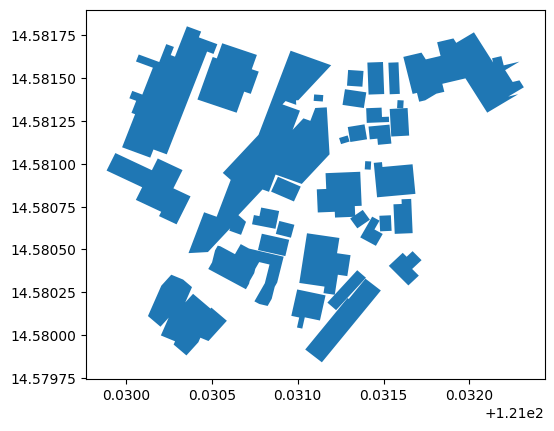

In [185]:
area_roads.plot()

<Axes: >

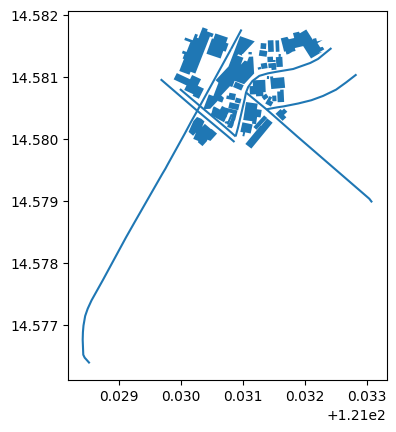

In [186]:
random_patch_roads = dataset_roads.cx[minx:maxx, miny:maxy]
random_patch_roads_geom = random_patch_roads['geometry']
combined_graphs = pd.concat([area_roads, random_patch_roads_geom], ignore_index=True)
combined_graphs.plot()

<Axes: >

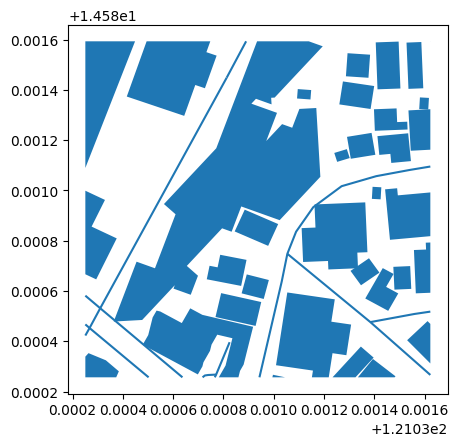

In [187]:
clipped = combined_graphs.clip(bbox)
clipped.plot()

In [188]:
clipped

34    LINESTRING (121.03027 14.58045, 121.03025 14.5...
19    POLYGON ((121.03026 14.58035, 121.03033 14.580...
42    LINESTRING (121.03027 14.58045, 121.0305 14.58...
46    LINESTRING (121.03077 14.58027, 121.03074 14.5...
41    LINESTRING (121.03064 14.58026, 121.03031 14.5...
40    LINESTRING (121.03082 14.5804, 121.03077 14.58...
20    POLYGON ((121.03081 14.5803, 121.03084 14.5804...
38    LINESTRING (121.03031 14.58053, 121.03027 14.5...
44    LINESTRING (121.03031 14.58053, 121.03025 14.5...
2     POLYGON ((121.03079 14.58074, 121.03089 14.580...
35    LINESTRING (121.03162 14.58027, 121.03138 14.5...
24    POLYGON ((121.03153 14.5804, 121.03161 14.5804...
16    POLYGON ((121.03146 14.58052, 121.03136 14.580...
15    POLYGON ((121.03155 14.58061, 121.03148 14.580...
27    POLYGON ((121.03162 14.58079, 121.03162 14.580...
37    LINESTRING (121.03162 14.5811, 121.03154 14.58...
36    LINESTRING (121.03162 14.58052, 121.03156 14.5...
33    POLYGON ((121.03149 14.58101, 121.03149 14

<Axes: >

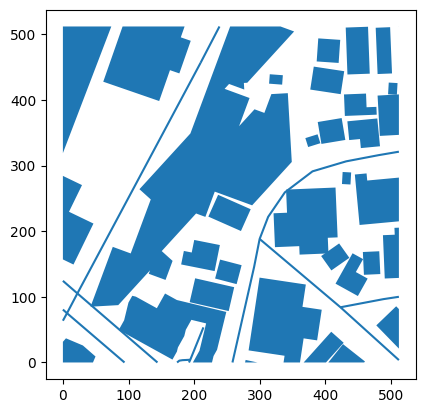

In [189]:
copy = clipped.copy()
copy.set_crs(None, allow_override=True, inplace=True)

copy = copy.apply(
    lambda geom: shift_geometry(geom, minx, miny)
)
copy = copy.apply(
    lambda geom: scale_geometry(geom, 512/(maxx-minx), 512/(maxy-miny))
)
copy.plot()

In [190]:
clipped_gdf = gpd.GeoDataFrame(geometry=clipped)
clipped_gdf.set_crs(None, allow_override=True, inplace=True)

,geometry
34,"LINESTRING (121.03027 14.58045, 121.03025 14.5..."
19,"POLYGON ((121.03026 14.58035, 121.03033 14.580..."
42,"LINESTRING (121.03027 14.58045, 121.0305 14.58..."
46,"LINESTRING (121.03077 14.58027, 121.03074 14.5..."
41,"LINESTRING (121.03064 14.58026, 121.03031 14.5..."
40,"LINESTRING (121.03082 14.5804, 121.03077 14.58..."
20,"POLYGON ((121.03081 14.5803, 121.03084 14.5804..."
38,"LINESTRING (121.03031 14.58053, 121.03027 14.5..."
44,"LINESTRING (121.03031 14.58053, 121.03025 14.5..."
2,"POLYGON ((121.03079 14.58074, 121.03089 14.580..."


<Axes: >

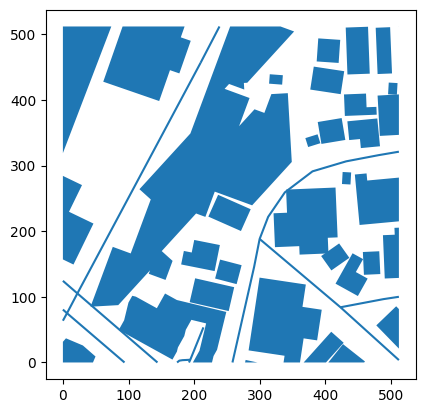

In [191]:
scaled_clipped = clipped_gdf['geometry'].apply(
    lambda geom: shift_geometry(geom, minx, miny)
)
scaled_clipped = scaled_clipped.apply(
    lambda geom: scale_geometry(geom, 512/(maxx-minx), 512/(maxy-miny))
)
scaled_clipped.plot()